In [156]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
import torch
from datasets import load_dataset
from mini_yolov3.dataset import SVNHDataset, collate_fn
from mini_yolov3.inference import non_maximum_suppression
from mini_yolov3.utils import coco_to_xyxy, draw_bounding_boxes, draw_grid, box_iou
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from mini_yolov3.loss import build_target, YOLOLoss, build_targets

In [185]:
dataset = SVNHDataset(split="train", image_size=64, normalize=True, type="tensor", bbox_format="xywh")

In [186]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [212]:
anchors = torch.Tensor([[0.2, 0.8], [0.8, 0.2]])

In [224]:
for x in dataloader:
    bbox = x["bbox"]
    labels = x["labels"]

    print(bbox)

    target = build_targets(bbox, grid_size=2, labels=labels, anchors=anchors, bbox_format="xywh")

    break

[tensor([[0.4533, 0.4565, 0.1963, 0.8696],
        [0.6075, 0.5000, 0.1495, 0.8696]])]
building targets
A 2
cell size: 0.5
xy tensor([[0.4533, 0.4565],
        [0.6075, 0.5000]])
cell and offsets
tensor([[0, 0],
        [1, 1]], dtype=torch.int32) tensor([[0.0000, 0.0000],
        [0.5000, 0.5000]])


In [226]:
target[:, :, 0, 0]

tensor([[-0.1875, -0.1744, -0.0189,  0.0834, -1.4052,  1.4697,  1.0000,  4.0000]])

In [162]:
target[0][:, 1, 1]

tensor([0.6075, 0.5000, 0.1495, 0.8696, 1.0000, 6.0000])

In [163]:
item = dataset[0]
image = item["image"]
image

tensor([[[0.9569, 0.9529, 0.9490,  ..., 0.9569, 0.9569, 0.9529],
         [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
         [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
         ...,
         [0.9569, 0.9569, 0.9569,  ..., 0.9451, 0.9490, 0.9529],
         [0.9608, 0.9608, 0.9608,  ..., 0.9451, 0.9490, 0.9529],
         [0.9647, 0.9647, 0.9647,  ..., 0.9490, 0.9529, 0.9569]],

        [[0.9922, 0.9882, 0.9843,  ..., 0.9882, 0.9882, 0.9843],
         [0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9843, 0.9843],
         [0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9843, 0.9843],
         ...,
         [0.9843, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.9804],
         [0.9843, 0.9843, 0.9843,  ..., 0.9804, 0.9804, 0.9804],
         [0.9804, 0.9804, 0.9843,  ..., 0.9765, 0.9765, 0.9765]],

        [[0.9882, 0.9843, 0.9804,  ..., 0.9961, 0.9961, 0.9922],
         [0.9843, 0.9843, 0.9843,  ..., 0.9922, 0.9922, 0.9922],
         [0.9843, 0.9843, 0.9843,  ..., 0.9922, 0.9922, 0.

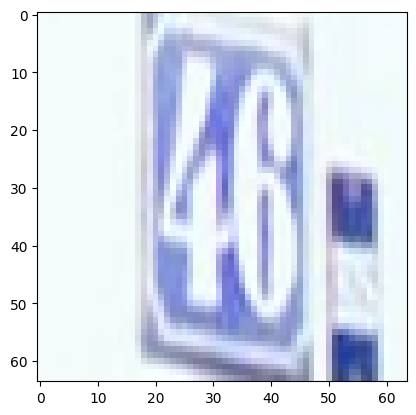

In [164]:
plt.imshow(image.permute(1, 2, 0))

In [165]:
plt.imshow(draw_grid(image, grid_size=64//2))

AttributeError: 'Tensor' object has no attribute 'copy'

In [166]:
pred = torch.zeros((1, 2 * (5 + 10), 2, 2))
pred.shape

torch.Size([1, 30, 2, 2])

In [167]:
pred[0, :5, 0, 0] = target[0, :5 , 0, 0]
pred[0, 8] = 0.9
pred[0, 4, 0, 0] = 0.9
pred[0, 15: 20, 0, 0] = target[0, :5, 0, 0]
pred[0, 15, 0, 0] -= 0.1

pred[0, 4, 0, 1] = 0.3

pred[0, 15:20, 1, 1] = target[0, :5 , 1, 1]
pred[0, 15:17, 1, 1] -= 0.53
# pred[0, 15:19, 1, 1] -= 0.01
pred[0, 25, 1, 1] = 0.9

In [168]:
pred[0, :, 1, 1]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.9000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0775,
        -0.0300,  0.1495,  0.8696,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.9000,  0.0000,  0.0000,  0.0000,  0.0000])

In [169]:
criterion = YOLOLoss(num_anchors=2)

In [170]:
criterion(pred, bbox, labels)

tensor([[0, 0],
        [1, 1]], dtype=torch.int32)


tensor(2.5811)

In [174]:
non_maximum_suppression(pred)

tensor([[[[ 0.4533,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.4565,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.1963,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.8696,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.9000,  0.3000],
          [ 0.0000,  0.0000]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.9000,  0.9000],
          [ 0.9000,  0.9000]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.3533,  0.0000],
          [ 0.0000,  0.0775]],

        